# Estimating Indirect Nutrient Load from PT

# Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Function 

In [2]:
# Define the function to sort the files based on the time
def sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('_')[-1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Inputs

In [15]:

# -----------------------------
# Define Core Directories
# -----------------------------
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # For general GIS layers
#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Erase_Riperian'  # Coastal wetlands (50m buffer)
# CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'  # Alternative path (optional)
CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Buff_CW'
# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------
# CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50.shp')
# CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50.shp')
# CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50.shp')
# CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50.shp')
CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50_buff50_removeoverlap.shp')
CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50_buff50_removeoverlap.shp')
CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50_buff50_removeoverlap.shp')
CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50_buff50_removeoverlap.shp')
# Load shapefiles as GeoDataFrames
CW_avg   = gpd.read_file(CW_avg_path)
CW_low   = gpd.read_file(CW_low_path)
CW_high  = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# -----------------------------
# FVCOM Particle Tracking Output Files
# -----------------------------
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'
files = glob.glob(os.path.join(data_dir, "particleload_updated_FVCOM_Huron_2424_*.nc"))
files.sort(key=sort_key)

# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

# -----------------------------
# Direct Nutrient Load (Stream Watersheds)
# -----------------------------
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/DirectTNTP_StreamWatresheds.csv'
DirectStreamWatershed_NutrientLoad = pd.read_csv(Direct_Nutrient_load)

# Optional: Rename columns to standard NetCDF field names
required_columns = {
    'Group_id': 'group_id',
    'StreamDirectTN_kgday': 'StreamDirectTN_kgday',
    'StreamDirectTP_kgday': 'StreamDirectTP_kgday',
    'StreamDirectTN_grm2day': 'StreamDirectTN_grm2day',
    'StreamDirectTP_grm2day': 'StreamDirectTP_grm2day'
}
DirectStreamWatershed_NutrientLoad.rename(columns=required_columns, inplace=True)

# read pylag outputs 
# Gather and sort NetCDF files
updated_files = glob.glob(os.path.join(data_dir, "particleload_updated_FVCOM_Huron_2424_*.nc"))
updated_files.sort(key=sort_key)

# Alias for clarity
nc_files = updated_files
print(nc_files)


['/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_FebMar_2.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_MarApr_3.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_AprMay_4.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_MayJun_5.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_JunJul_6.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_JulAug_7.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_AugSep_8.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_SepOct_9.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2424_OctNov_10.nc', '/home/abolmaal/modelling/FV

In [16]:
#set the crs of cw_avg to 3174
CW_avg.crs = 'EPSG:3174'
CW_low.crs = 'EPSG:3174'
CW_high.crs = 'EPSG:3174'
CW_surge.crs = 'EPSG:3174'
# CW_avg.to_crs('EPSG:3174', inplace=True)
# CW_low.to_crs('EPSG:3174', inplace=True)
# CW_high.to_crs('EPSG:3174', inplace=True)
# CW_surge.to_crs('EPSG:3174', inplace=True)

# Outputs

In [ ]:
# Define the year suffix
year = 2024
year_suffix = str(year)[-2:]  # '24' if year is 2024

# Output paths
#output_path = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load'
output_path = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour'
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/figures/InDirectNPLoad'

# FVCOM model output shapefile
originalFVCOM = f'LakeHuronparticletracking_{year}_original.shp'

# Intersected outputs with coastal wetlands
Intersection_PTCW_Avg = f'Intersections_Avg_PTCW_{year_suffix}.csv'
Intersection_PTCW_high = f'Intersections_high_PTCW_{year_suffix}.csv'
Intersection_PTCW_low = f'Intersections_low_PTCW_{year_suffix}.csv'
Intersection_PTCW_surge = f'Intersections_surge_PTCW_{year_suffix}.csv'
# Intersection summary
Intersection_summary_avg = f'Intersection_summary_PTCW_avg_{year_suffix}.csv'
Intersection_summary_high = f'Intersection_summary_PTCW_high_{year_suffix}.csv'
Intersection_summary_low = f'Intersection_summary_PTCW_low_{year_suffix}.csv'
Intersection_summary_surge = f'Intersection_summary_PTCW_surge_{year_suffix}.csv'

# Monthly intersected outputs
Intersection_PTCW_Avg_monthly = f'Intersections_Avg_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_high_monthly = f'Intersections_high_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_low_monthly = f'Intersections_low_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_surge_monthly = f'Intersections_surge_PTCW_monthly_{year_suffix}.csv'

# Group ID and Non-intersections
GroupIdcount = f'group_id_counts_{year_suffix}.csv'
Non_Intersection_avg = f'Non_Intersection_avg_{year_suffix}.csv'
Non_Intersection_high = f'Non_Intersection_high_{year_suffix}.csv'
Non_Intersection_low = f'Non_Intersection_low_{year_suffix}.csv'
Non_Intersection_surge = f'Non_Intersection_surge_{year_suffix}.csv'

# outnames for the figures
fig_histogram = f'Histogram_PTCW_{year_suffix}.png'


# Parameters

In [22]:

release_times = ["2401", "2402", "2403", "2404", "2405", "2406", "2407", "2408", "2409", "2410", "2411", "2412"]

# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface
reversed_plasma_cmap = plasma_cmap.reversed()  # Reversed colormap  
# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_gramday'
StreamDirectTP = 'StreamDirectTP_gramday'


# Creating a geodaframe for each individual run, then find the first intersection with the coastal wetlands and save the results


In [32]:
def save_first_intersection_per_file_with_stats(nc_file, CW, output_dir, release_time_str, cw_level):
    """
    Processes a single NetCDF file to:
    - Extract particle data
    - Fix longitudes >180
    - Convert to GeoDataFrame
    - Compute first intersection with CW shapefile
    - Save results and print intersection percentage

    Returns:
    - percentage: float, percent of intersected particles
    - total_particles: int
    - intersected_particles: int
    """
    print(f"🔍 Processing {os.path.basename(nc_file)} with release time {release_time_str} for {cw_level}...")

    with xr.open_dataset(nc_file) as ds:
        selected_vars = ds[['time', 'group_id', 'particle_id', 'longitude', 'latitude',
                            'StreamTN_gramdayparticle', 'StreamTP_gramdayparticle']]

        # Fix longitudes > 180°
        selected_vars['longitude'].values = np.where(
            selected_vars['longitude'].values > 180,
            selected_vars['longitude'].values - 360,
            selected_vars['longitude'].values
        )

        df = selected_vars.to_dataframe().reset_index()

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
    gdf.set_crs('EPSG:4326', inplace=True)
    gdf = gdf.to_crs('EPSG:3174')  # Match CW CRS

    total_particles = gdf['particle_id'].nunique()

    # Intersections
    intersecting = gdf[gdf.geometry.intersects(CW.geometry.union_all())]

    if not intersecting.empty:
        intersecting = intersecting.sort_values(by=['particle_id', 'time'])
        first_intersections = intersecting.drop_duplicates(subset='particle_id', keep='first')

        # Spatial join with CW info
        joined = gpd.sjoin(
            first_intersections,
            CW[['geometry', 'CW_Area', 'CW_Id', 'ID_Coastal', 'Wetland','start_lat','start_lon']],
            how='inner',
            predicate='intersects'
        )

        output_csv = os.path.join(output_dir, f"intersection_{release_time_str}_{cw_level}.csv")
        joined.to_csv(output_csv, index=False)

        intersected_particles = joined['particle_id'].nunique()
        percentage = (intersected_particles / total_particles) * 100 if total_particles else 0

        print(f"✅ {intersected_particles}/{total_particles} particles intersected ({percentage:.2f}%) — saved to {output_csv}")
    else:
        intersected_particles = 0
        percentage = 0
        print(f"⚠️ No intersections found for {release_time_str} with {cw_level}.")

    gc.collect()
    return percentage, total_particles, intersected_particles

# change the time period of intersecting 

In [ ]:
import os
import gc
import numpy as np
import geopandas as gpd
import xarray as xr
import pandas as pd
from shapely.geometry import Point
from netCDF4 import num2date

def save_first_intersection_per_file_with_stats(
    nc_file, CW, output_dir, release_time_str, cw_level, days_limit=15
):
    """
    Processes a single NetCDF file to:
    - Extract particle data within a time window (e.g., first 15 days)
    - Fix longitudes >180
    - Convert to GeoDataFrame
    - Compute first intersection with CW shapefile
    - Save results and print intersection percentage

    Parameters
    ----------
    nc_file : str
        Path to NetCDF file
    CW : GeoDataFrame
        Coastal wetlands shapefile (in EPSG:3174)
    output_dir : str
        Where to save results
    release_time_str : str
        Release time identifier (for naming files)
    cw_level : str
        Label for CW layer
    days_limit : int
        Number of days from start of file to keep (default = 15)

    Returns
    -------
    percentage : float
        Percent of intersected particles
    total_particles : int
    intersected_particles : int
    """
    print(f"🔍 Processing {os.path.basename(nc_file)} | Release {release_time_str} | CW {cw_level} | Days limit = {days_limit} ")

    with xr.open_dataset(nc_file) as ds:
        selected_vars = ds[['time', 'group_id', 'particle_id', 'longitude', 'latitude',
                            'StreamTN_gramdayparticle', 'StreamTP_gramdayparticle']]

        # Decode time properly
        time_var = ds['time']
        units = time_var.attrs.get('units', None)
        calendar = time_var.attrs.get('calendar', 'standard')

        if units is not None:
            # Standard case: use CF-compliant units
            converted_time = num2date(time_var[:], units=units, calendar=calendar)
            converted_time = pd.to_datetime(converted_time)  # ensure pandas datetime
        else:
            # Case 1: Already datetime64
            if np.issubdtype(time_var.dtype, np.datetime64):
                converted_time = pd.to_datetime(time_var.values)
            else:
                # Case 2: Missing units → assume "seconds since first timestep"
                print("⚠️ 'units' missing: assuming relative seconds since start of file")
                start = pd.Timestamp("2000-01-01")  # arbitrary reference if needed
                converted_time = pd.to_datetime(start + pd.to_timedelta(time_var.values, unit="s"))

        # Define cutoff
        cutoff_time = converted_time[0] + pd.Timedelta(days=days_limit)

        # Mask by time window
        mask = converted_time <= cutoff_time
        selected_vars = selected_vars.isel(time=mask)

        # Fix longitudes > 180°
        selected_vars['longitude'].values = np.where(
            selected_vars['longitude'].values > 180,
            selected_vars['longitude'].values - 360,
            selected_vars['longitude'].values
        )

        # Convert to DataFrame
        df = selected_vars.to_dataframe().reset_index()

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
    gdf.set_crs('EPSG:4326', inplace=True)
    gdf = gdf.to_crs('EPSG:3174')  # Match CW CRS

    total_particles = gdf['particle_id'].nunique()

    # Intersections
    intersecting = gdf[gdf.geometry.intersects(CW.geometry.union_all())]

    if not intersecting.empty:
        intersecting = intersecting.sort_values(by=['particle_id', 'time'])
        first_intersections = intersecting.drop_duplicates(subset='particle_id', keep='first')

        # Spatial join with CW info
        joined = gpd.sjoin(
            first_intersections,
            CW[['geometry', 'CW_Area', 'CW_Id', 'ID_Coastal', 'Wetland', 'start_lat', 'start_lon']],
            how='inner',
            predicate='intersects'
        )

        output_csv = os.path.join(output_dir, f"intersection_{release_time_str}_{cw_level}_first{days_limit}days.csv")
        joined.to_csv(output_csv, index=False)

        intersected_particles = joined['particle_id'].nunique()
        percentage = (intersected_particles / total_particles) * 100 if total_particles else 0

        print(f"✅ {intersected_particles}/{total_particles} particles intersected ({percentage:.2f}%) — saved to {output_csv}")
    else:
        intersected_particles = 0
        percentage = 0
        print(f"⚠️ No intersections found for {release_time_str} with {cw_level}.")

    gc.collect()
    return percentage, total_particles, intersected_particles


##### Intersection for different tracking time periods #############

In [20]:
summary_data = []
days_limit = 90 # <-- change this value if you want different periods
 
 # Step 2: Loop through each file and release time
for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(
    file, CW_avg, output_path, rtime, cw_level='avg', days_limit=days_limit
    )
    summary_data.append({
    'release_time': rtime,
    'total_particles': total,
    'intersected_particles': intersected,
    'percentage': round(pct, 2)
    })
 
 # Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, f"Intersection_summary_avg_{days_limit}day.csv")
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc | Release 2301 | CW avg | Days limit = 90
✅ 2103/8550 particles intersected (24.60%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/intersection_2301_avg_first90days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_FebMar_2.nc | Release 2302 | CW avg | Days limit = 90
✅ 1511/8550 particles intersected (17.67%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/intersection_2302_avg_first90days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MarApr_3.nc | Release 2303 | CW avg | Days limit = 90
✅ 5064/8550 particles intersected (59.23%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/intersection_2303_avg_first90days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_AprMay_4.nc | Release 2304 | CW avg | Days limit = 90
✅ 2431/8550 particles intersected (28.43%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeda

In [ ]:
# Define the day limits you want to test
day_limits = [1, 5, 10, 26, 60, 90]

for d in day_limits:
    print(f"\n⏳ Running intersections for days_limit = {d}")

    summary_data = []

    # Loop through each file and release time
    for file, rtime in zip(updated_files, release_times):
        pct, total, intersected = save_first_intersection_per_file_with_stats(
            file, CW_avg, output_path, rtime, cw_level='surge', days_limit=d
        )
        summary_data.append({
            'release_time': rtime,
            'total_particles': total,
            'intersected_particles': intersected,
            'percentage': round(pct, 2),
            'days_limit': d
        })

    # Save summary stats for this day_limit
    summary_df = pd.DataFrame(summary_data)
    summary_csv = os.path.join(output_path, f"Intersection_summary_{cw_level}_{d}days_{year_suffix}.csv")
    summary_df.to_csv(summary_csv, index=False)
    print(f"📄 Saved summary for {d} days → {summary_csv}")


⏳ Running intersections for days_limit = 1
🔍 Processing particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc | Release 2301 | CW surge | Days limit = 1
✅ 375/8550 particles intersected (4.39%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2301_surge_first1days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_FebMar_2.nc | Release 2302 | CW surge | Days limit = 1
✅ 147/8550 particles intersected (1.72%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2302_surge_first1days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_MarApr_3.nc | Release 2303 | CW surge | Days limit = 1
✅ 186/8550 particles intersected (2.18%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2303_surge_first1days.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_AprMay_4.nc | Release 2304 | CW surge | Days limit = 1
✅ 1566/8550 particles intersected (18.32%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectN

##### Intersection for different time periods ###########

# Intersection with avg Inundation

In [33]:
# running the function to find the intersection of the particles with the coastal wetlands with the average inundation level
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_avg, output_path, rtime,cw_level='avg')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_avg)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc with release time 2401 for avg...
✅ 1930/8550 particles intersected (22.57%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2401_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_FebMar_2.nc with release time 2402 for avg...
✅ 3922/8550 particles intersected (45.87%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2402_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_MarApr_3.nc with release time 2403 for avg...
✅ 2246/8550 particles intersected (26.27%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2403_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_AprMay_4.nc with release time 2404 for avg...
✅ 4487/8550 particles intersected (52.48%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2404_avg.csv
🔍 Processing particleload_up

# Intersection with high Inundation

In [44]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_high, output_path, rtime,cw_level='high')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_high)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")


🔍 Processing particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc with release time 2401 for high...
✅ 1861/8550 particles intersected (21.77%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2401_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_FebMar_2.nc with release time 2402 for high...
✅ 3997/8550 particles intersected (46.75%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2402_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_MarApr_3.nc with release time 2403 for high...
✅ 2197/8550 particles intersected (25.70%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2403_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_AprMay_4.nc with release time 2404 for high...
✅ 4271/8550 particles intersected (49.95%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2404_high.csv
🔍 Processing particl

# Intersection with low Inundation

In [45]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_low, output_path, rtime,cw_level='low')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_low)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc with release time 2401 for low...
✅ 1945/8550 particles intersected (22.75%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2401_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_FebMar_2.nc with release time 2402 for low...
✅ 3260/8550 particles intersected (38.13%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2402_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_MarApr_3.nc with release time 2403 for low...
✅ 1883/8550 particles intersected (22.02%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2403_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_AprMay_4.nc with release time 2404 for low...
✅ 3761/8550 particles intersected (43.99%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2404_low.csv
🔍 Processing particleload_up

# Intersection with surge Inundation

In [47]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_surge, output_path, rtime,cw_level='surge')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_surge)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2424_JanFeb_1.nc with release time 2401 for surge...
✅ 1796/8550 particles intersected (21.01%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2401_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_FebMar_2.nc with release time 2402 for surge...
✅ 4043/8550 particles intersected (47.29%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2402_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_MarApr_3.nc with release time 2403 for surge...
✅ 2199/8550 particles intersected (25.72%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2403_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2424_AprMay_4.nc with release time 2404 for surge...
✅ 4243/8550 particles intersected (49.63%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/intersection_2404_surge.csv
🔍 Processing

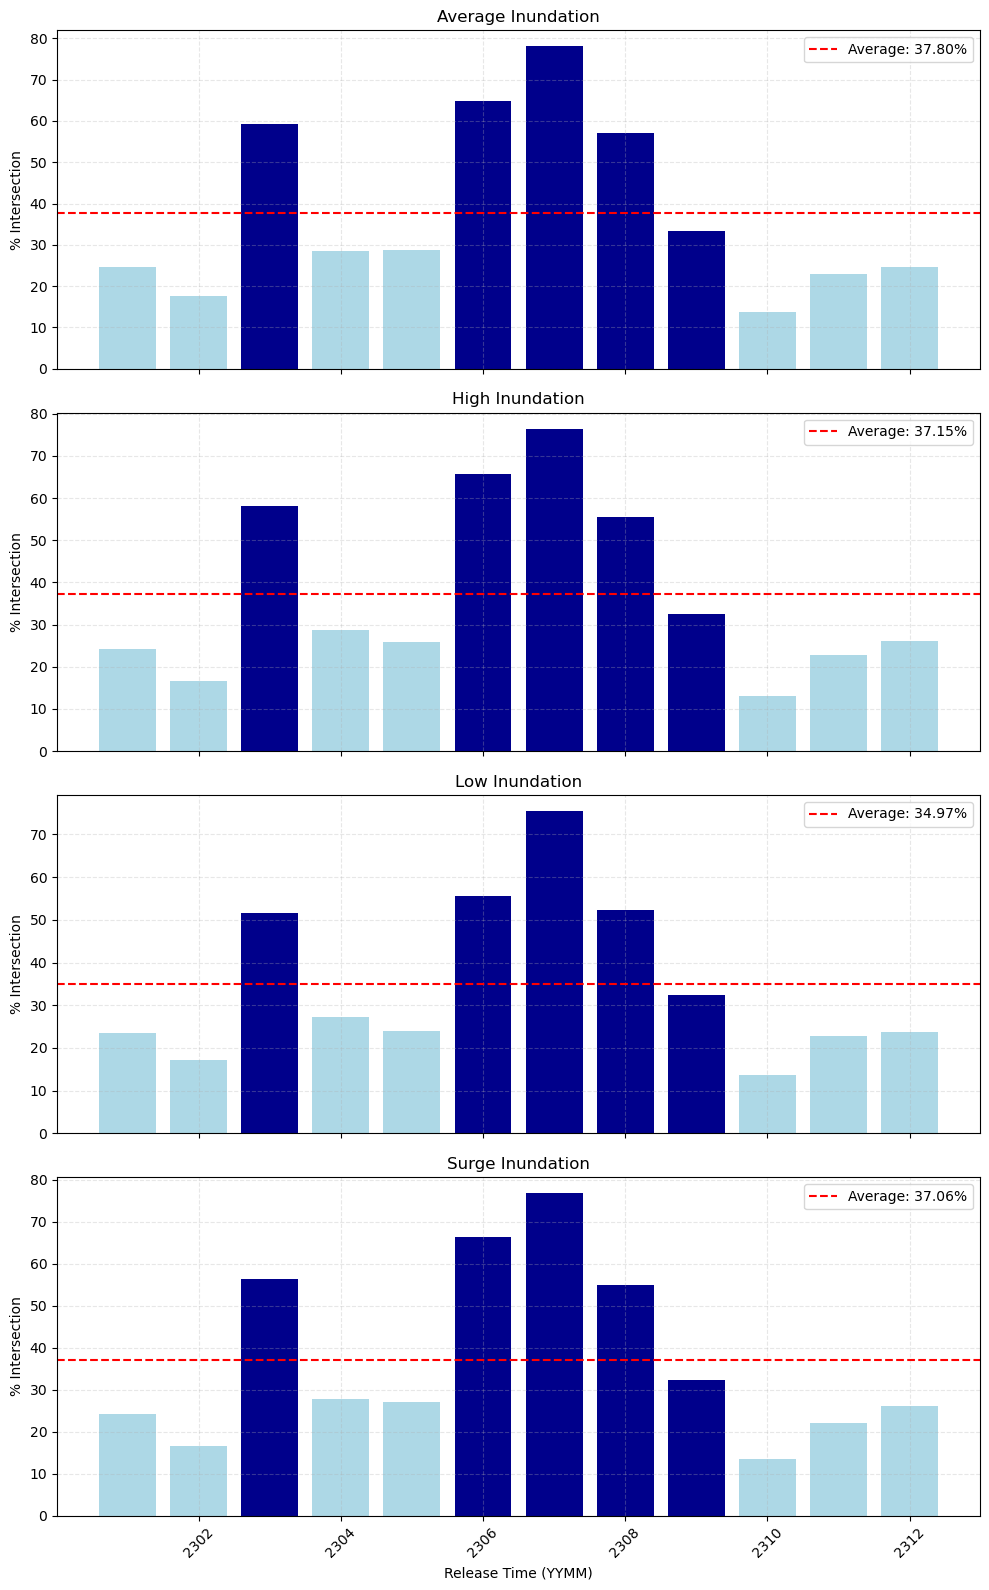

In [ ]:

# read the summary CSV files for avg, high, low, and surge inundation levels
summary_avg = pd.read_csv(os.path.join(output_path, Intersection_summary_avg))
summary_high = pd.read_csv(os.path.join(output_path, Intersection_summary_high))
summary_low = pd.read_csv(os.path.join(output_path, Intersection_summary_low))
summary_surge = pd.read_csv(os.path.join(output_path, Intersection_summary_surge))

# Store all summaries in a list with labels
summaries = [
    ('Average Inundation', summary_avg),
    ('High Inundation', summary_high),
    ('Low Inundation', summary_low),
    ('Surge Inundation', summary_surge)
]

# Create 4,1 subplot layout
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

for ax, (title, summary_df) in zip(axes, summaries):
    # Step 1: Conditional colors
    colors = ['darkblue' if p >= 30 else 'lightblue' for p in summary_df['percentage']]
    
    # Step 2: Bar plot
    ax.bar(summary_df['release_time'], summary_df['percentage'], color=colors)
    
    # Step 3: Average line
    avg = summary_df['percentage'].mean()
    ax.axhline(y=avg, color='red', linestyle='--', label=f'Average: {avg:.2f}%')
    
    # Step 4: Titles and styling
    ax.set_title(title)
    ax.set_ylabel('% Intersection')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)

# Shared x-label and formatting
axes[-1].set_xlabel('Release Time (YYMM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_figures, fig_histogram), dpi=300)
plt.show()

In [40]:
Intersection_summary_one = 'Intersection_summary_surge_oneday.csv'
Intersection_summary_10 = 'Intersection_summary_surge_10days.csv'
Intersection_summary_5 = 'Intersection_summary_surge_5days.csv'
Intersection_summary_26 = 'Intersection_summary_surge_26days.csv'
Intersection_summary_60 = 'Intersection_summary_surge_60days.csv'
Intersection_summary_90 = 'Intersection_summary_surge_90days.csv'

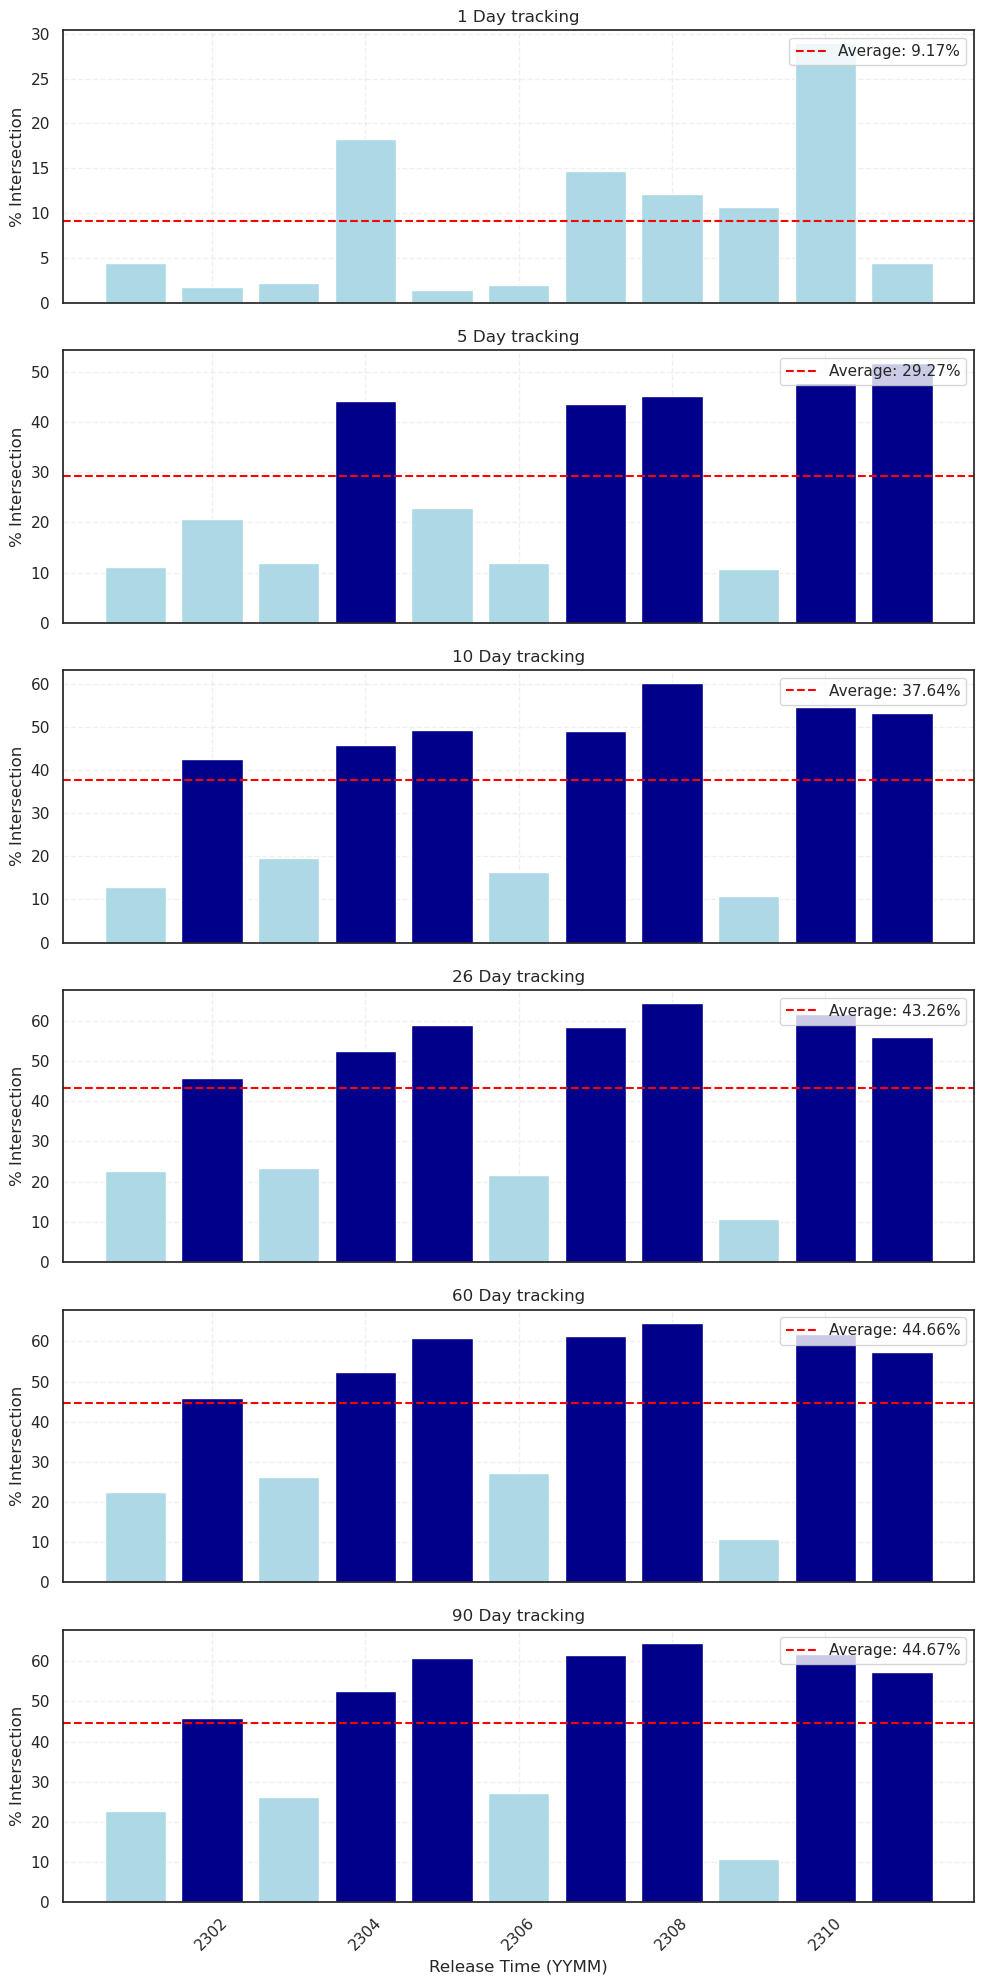

In [41]:
# read the summary CSV files for avg, high, low, and surge inundation levels
summary_one = pd.read_csv(os.path.join(output_path, Intersection_summary_one))
summary_10 = pd.read_csv(os.path.join(output_path, Intersection_summary_10))
summary_5 = pd.read_csv(os.path.join(output_path, Intersection_summary_5))
summary_26 = pd.read_csv(os.path.join(output_path, Intersection_summary_26))
summary_60 = pd.read_csv(os.path.join(output_path, Intersection_summary_60))
summary_90 = pd.read_csv(os.path.join(output_path, Intersection_summary_90))

# Store all summaries in a list with labels
summaries = [
    ('1 Day tracking', summary_one),
    ('5 Day tracking', summary_5),
    ('10 Day tracking', summary_10),
    ('26 Day tracking', summary_26),
    ('60 Day tracking', summary_60),
    ('90 Day tracking', summary_90)
]

# Create 5,1 subplot layout
fig, axes = plt.subplots(6, 1, figsize=(10, 20), sharex=True)

for ax, (title, summary_df) in zip(axes, summaries):
    # Step 1: Conditional colors
    colors = ['darkblue' if p >= 30 else 'lightblue' for p in summary_df['percentage']]
    
    # Step 2: Bar plot
    ax.bar(summary_df['release_time'], summary_df['percentage'], color=colors)
    
    # Step 3: Average line
    avg = summary_df['percentage'].mean()
    ax.axhline(y=avg, color='red', linestyle='--', label=f'Average: {avg:.2f}%')
    
    # Step 4: Titles and styling
    ax.set_title(title)
    ax.set_ylabel('% Intersection')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)

# Shared x-label and formatting
axes[-1].set_xlabel('Release Time (YYMM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_figures, fig_histogram), dpi=300)
plt.show()

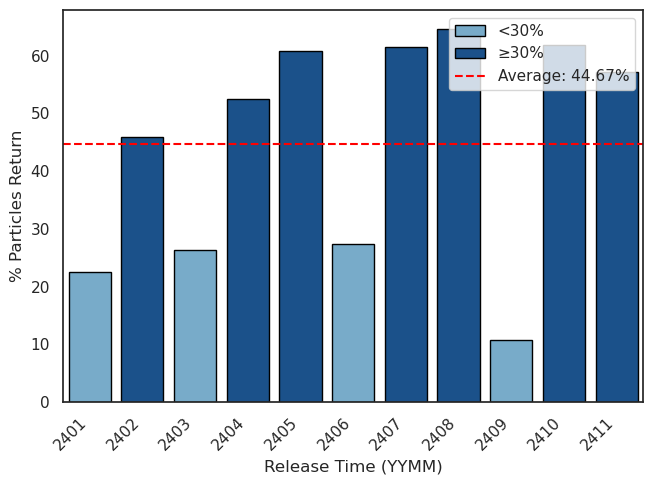

In [35]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

summary_avg = pd.read_csv(os.path.join(output_path, Intersection_summary_avg))

# Make a tidy helper column for conditional color
summary_avg["class"] = np.where(summary_avg["percentage"] >= 30, "≥30%", "<30%")

# (Optional) keep the original temporal order on x
summary_avg["release_time"] = summary_avg["release_time"].astype(str)
summary_avg["release_time"] = pd.Categorical(
    summary_avg["release_time"],
    categories=sorted(summary_avg["release_time"].unique()),
    ordered=True
)

sns.set_theme(style="white")

plt.figure(figsize=(6.69, 5))
ax = sns.barplot(
    data=summary_avg,
    x="release_time", y="percentage",
    hue="class", dodge=False,
    palette={"≥30%": "#08519c", "<30%": "#6baed6"}, edgecolor="black",
    errorbar=None
)

# Average line
average_percentage = summary_avg["percentage"].mean()
ax.axhline(average_percentage, color="red", linestyle="--")

# Labels & legend
ax.set_xlabel("Release Time (YYMM)")
ax.set_ylabel("% Particles Return")
#ax.set_title("Particle Tracking Intersection with Coastal Wetlands")
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")

# Merge seaborn legend with avg-line label
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.lines[-1])
labels.append(f"Average: {average_percentage:.2f}%")
ax.legend(handles, labels, loc="upper right", frameon=True)

plt.tight_layout()
plt.savefig(os.path.join(output_figures, "Histogram_PTCW_avg_2024.jpeg"), dpi=300)
plt.show()


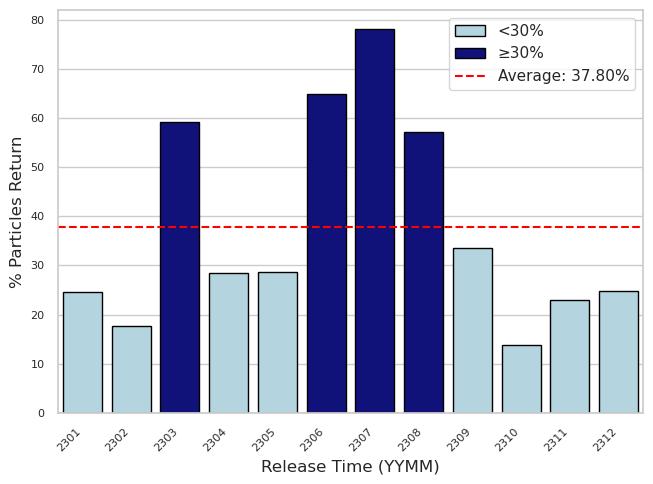

In [42]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

summary_avg = pd.read_csv(os.path.join(output_path, Intersection_summary_avg))

# Make a tidy helper column for conditional color
summary_avg["class"] = np.where(summary_avg["percentage"] >= 40, "≥30%", "<30%")

# (Optional) keep the original temporal order on x
summary_avg["release_time"] = summary_avg["release_time"].astype(str)
summary_avg["release_time"] = pd.Categorical(
    summary_avg["release_time"],
    categories=sorted(summary_avg["release_time"].unique()),
    ordered=True
)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(6.69, 5))
ax = sns.barplot(
    data=summary_avg,
    x="release_time", y="percentage",
    hue="class", dodge=False,
    palette={"≥30%": "darkblue", "<30%": "lightblue"}, edgecolor="black",
    errorbar=None
)

# Average line
average_percentage = summary_avg["percentage"].mean()
ax.axhline(average_percentage, color="red", linestyle="--")

# Labels & legend
ax.set_xlabel("Release Time (YYMM)", fontsize=12)
ax.set_ylabel("% Particles Return", fontsize=12)
ax.tick_params(axis="both", labelsize=8)
#ax.set_title("Particle Tracking Intersection with Coastal Wetlands")
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")

# Merge seaborn legend with avg-line label
handles, labels = ax.get_legend_handles_labels()
handles.append(ax.lines[-1])
labels.append(f"Average: {average_percentage:.2f}%")
ax.legend(handles, labels, loc="upper right", frameon=True)

plt.tight_layout()
plt.savefig(os.path.join(output_figures, "Histogram_PTCW_avg_2023.jpeg"), dpi=300)
plt.show()


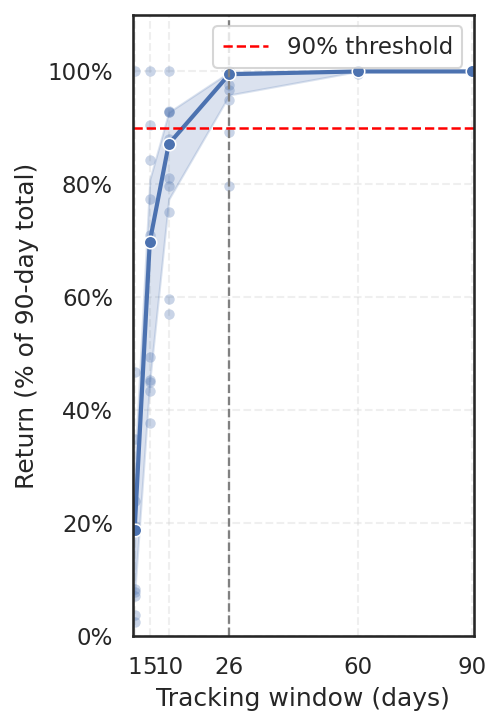

Median fraction at 26 days: 99.5%


In [88]:
import os
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- paths & filenames (you already have these) ---
output_path = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour'
Intersection_summary_one = 'Intersection_summary_surge_oneday.csv'
Intersection_summary_5   = 'Intersection_summary_surge_5days.csv'
Intersection_summary_10  = 'Intersection_summary_surge_10days.csv'
Intersection_summary_26  = 'Intersection_summary_surge_26days.csv'
Intersection_summary_60  = 'Intersection_summary_surge_60days.csv'
Intersection_summary_90  = 'Intersection_summary_surge_90days.csv'

# --- 1) Read all six summaries and merge on release_time ---
summary_one = pd.read_csv(os.path.join(output_path, Intersection_summary_one))
summary_5   = pd.read_csv(os.path.join(output_path, Intersection_summary_5))
summary_10  = pd.read_csv(os.path.join(output_path, Intersection_summary_10))
summary_26  = pd.read_csv(os.path.join(output_path, Intersection_summary_26))
summary_60  = pd.read_csv(os.path.join(output_path, Intersection_summary_60))
summary_90  = pd.read_csv(os.path.join(output_path, Intersection_summary_90))

dfs = [
    summary_one[['release_time','percentage']].rename(columns={'percentage':'d1'}),
    summary_5  [['release_time','percentage']].rename(columns={'percentage':'d5'}),
    summary_10 [['release_time','percentage']].rename(columns={'percentage':'d10'}),
    summary_26 [['release_time','percentage']].rename(columns={'percentage':'d26'}),
    summary_60 [['release_time','percentage']].rename(columns={'percentage':'d60'}),
    summary_90 [['release_time','percentage']].rename(columns={'percentage':'d90'}),
]
df_all = reduce(lambda l, r: pd.merge(l, r, on='release_time', how='inner'), dfs)

# Ensure numeric
for c in ['d1','d5','d10','d26','d60','d90']:
    df_all[c] = pd.to_numeric(df_all[c], errors='coerce')

# Drop rows without a valid baseline
df_all = df_all[df_all['d90'].notna() & (df_all['d90'] > 0)].copy()

# If your percentages are 0–100, convert to 0–1 before normalizing
if df_all[['d1','d5','d10','d26','d60','d90']].max().max() > 1.5:
    df_all[['d1','d5','d10','d26','d60','d90']] = df_all[['d1','d5','d10','d26','d60','d90']] / 100.0

# --- 2) CREATE the normalized columns f_d* (this was missing) ---
df_all['f_d1']  = df_all['d1']  / df_all['d90']
df_all['f_d5']  = df_all['d5']  / df_all['d90']
df_all['f_d10'] = df_all['d10'] / df_all['d90']
df_all['f_d26'] = df_all['d26'] / df_all['d90']
df_all['f_d60'] = df_all['d60'] / df_all['d90']
df_all['f_d90'] = df_all['d90'] / df_all['d90']   # = 1.0

# Guard against division issues
df_all.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- 3) Long/“tidy” format for plotting ---
value_cols = ['f_d1','f_d5','f_d10','f_d26','f_d60','f_d90']
long = pd.melt(
    df_all[['release_time'] + value_cols],
    id_vars='release_time',
    value_vars=value_cols,
    var_name='which',
    value_name='frac'   # 0–1
)
long['days'] = long['which'].str.replace('f_d', '', regex=False).astype(int)

# --- 4) Plot in your target style ---
THRESH = 0.90
plt.figure(figsize=(3.5, 5), dpi=150)

# light scatter for all releases
sns.scatterplot(data=long, x='days', y='frac', alpha=0.30, s=25, linewidth=0)

# median line + IQR ribbon
sns.lineplot(
    data=long, x='days', y='frac',
    estimator='median', errorbar=('pi', 50),
    marker='o', linewidth=2
)

plt.axvline(26, ls='--', c='gray', lw=1.1)
plt.axhline(THRESH, ls='--', c='red',  lw=1.2, label=f'{int(THRESH*100)}% threshold')

ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.ylim(0, 1.10)
plt.xlim(0.5, 90.5)
plt.xticks([1, 5, 10, 26, 60, 90])
plt.xlabel('Tracking window (days)')
plt.ylabel('Return (% of 90-day total)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_figures, f'CumulativeReturn_vs_TrackingWindow_{year}.png'), dpi=300)
plt.show()

# quick readout
med26 = long.loc[long['days'] == 26, 'frac'].median()
print(f"Median fraction at 26 days: {med26*100:.1f}%")





# Estimating N P Loads

## Estimate the Total Indirect load for each Coastal wetland

The following code estimate the total N & P for each coastal wetland
then converts the values from gramday to gram/year/m2

In [55]:

import os
import glob
import pandas as pd

year = 24

def calculate_indirect_cw_flux(intersection_df):
    intersection_df['time'] = pd.to_datetime(intersection_df['time'])

    grouped = intersection_df.groupby('CW_Id', as_index=False).agg(
        totalTN_per_CW_Id=('StreamTN_gramdayparticle', 'sum'),
        totalTP_per_CW_Id=('StreamTP_gramdayparticle', 'sum'),
        CW_Area=('CW_Area', 'first'),
        Wetland=('Wetland', 'first'),
        start_lat=('start_lat', 'first'),
        start_lon=('start_lon', 'first'),
        group_ids=('group_id', lambda x: list(set(x))),
        particle_ids=('particle_id', lambda x: list(set(x))),
        count_group_id=('group_id', pd.Series.nunique),
        count_cw_id=('group_id', 'count'),
    )

    # Calculate total loads in g/m²/yr
    grouped['TotalIndirectCW_TN_grm2yr'] = (grouped['totalTN_per_CW_Id'] * 365) / grouped['CW_Area']
    grouped['TotalIndirectCW_TP_grm2yr'] = (grouped['totalTP_per_CW_Id'] * 365) / grouped['CW_Area']

    # 🔴 Remove extreme TN values > 10000 g/m²/yr
    #grouped = grouped[grouped['TotalIndirectCW_TN_grm2yr'] <= 10000]

    return grouped

def process_intersection_category(output_path, category):
    pattern = os.path.join(output_path, f"intersection_{year}??_{category}.csv")
    intersection_files = glob.glob(pattern)

    if not intersection_files:
        print(f"⚠️ No files found for category: {category}")
        return None

    # Read and tag each file with release_time
    intersection_dfs = []
    for file in intersection_files:
        df = pd.read_csv(file)
        df['release_time'] = os.path.basename(file).split('_')[1]
        intersection_dfs.append(df)

    intersection_df = pd.concat(intersection_dfs, ignore_index=True)
    
    # Save combined CSV
    combined_csv = os.path.join(output_path, f"intersection_all_{year}_{category}.csv")
    intersection_df.to_csv(combined_csv, index=False)

    # Calculate and return indirect CW flux
    flux_df = calculate_indirect_cw_flux(intersection_df)

    # Optionally save the output
    flux_csv = os.path.join(output_path, f"Indirect_CW_{category}_{year}.csv")
    flux_df.to_csv(flux_csv, index=False)
    
    print(f"✅ Processed category '{category}' → {len(flux_df)} CWs saved to {flux_csv}")
    return flux_df


In [50]:
year_suffix = 24
print(f"Processing indirect nutrient loads for year suffix: {year_suffix}")

Processing indirect nutrient loads for year suffix: 24


## apply the function to estimate the Indirect flux

In [56]:
# Example usage for multiple categories
categories = ["avg", "low", "high", "surge"]


results = {}
for cat in categories:
    results[cat] = process_intersection_category(output_path, cat)

✅ Processed category 'avg' → 1420 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_avg_24.csv
✅ Processed category 'low' → 1125 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_low_24.csv
✅ Processed category 'high' → 1535 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_high_24.csv
✅ Processed category 'surge' → 1705 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_surge_24.csv


In [60]:
# read the results
for cat in categories:
    file_path = os.path.join(output_path, f'Indirect_CW_{cat}_{year}_.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Category'] = cat  # Optional: tag the category inside the DataFrame
        var_name = f"Indirect_{cat}_{year}"
        globals()[var_name] = df  # Creates variable like Total_avg_23
        print(f"✅ Loaded: {var_name}")
    else:
        print(f"❌ File not found: {file_path}")

❌ File not found: /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_avg_24_.csv
❌ File not found: /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_low_24_.csv
❌ File not found: /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_high_24_.csv
❌ File not found: /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/twoenthyfour/Indirect_CW_surge_24_.csv


In [58]:
Indirect_low_24

NameError: name 'Indirect_low_24' is not defined

## Estimate Indirect N and P load for different tracking time 

In [59]:
def process_intersection_category(output_path, time_category, cw_levels=["avg", "low", "high", "surge"]):
    """
    Reads intersection outputs for a given time_category (e.g., 'first10days'),
    processes each CW level separately, and saves flux results.

    Parameters
    ----------
    output_path : str
        Directory containing intersection CSV files
    time_category : str
        String like 'first1days', 'first5days', 'first10days'
    cw_levels : list of str
        CW layers to process (default: ['avg','low','high','surge'])

    Returns
    -------
    dict of DataFrames keyed by cw_level
    """
    results = {}

    for cw in cw_levels:
        pattern = os.path.join(output_path, f"intersection_*_{cw}_{time_category}.csv")
        intersection_files = glob.glob(pattern)

        if not intersection_files:
            print(f"⚠️ No files found for {time_category} | CW '{cw}'")
            continue

        # Gather all releases for this cw_level
        dfs = []
        for file in intersection_files:
            df = pd.read_csv(file)
            df['release_time'] = os.path.basename(file).split('_')[1]
            df['days_limit'] = time_category
            dfs.append(df)

        intersection_df = pd.concat(dfs, ignore_index=True)

        # Save combined intersections
        combined_csv = os.path.join(output_path, f"intersection_all_{year}_{cw}_{time_category}.csv")
        intersection_df.to_csv(combined_csv, index=False)

        # Compute fluxes
        flux_df = calculate_indirect_cw_flux(intersection_df)
        flux_csv = os.path.join(output_path, f"Indirect_CW_{cw}_{year}_{time_category}.csv")
        flux_df.to_csv(flux_csv, index=False)

        print(f"✅ {time_category} | CW '{cw}' → {len(flux_df)} CWs saved to {flux_csv}")
        results[cw] = flux_df

    return results


In [28]:
categories = {"first1days", "first5days", "first10days", "first26days", "first60days", "first90days"}
results = {}
for cat in categories:
    results[cat] = process_intersection_category(output_path, cat)
    

/tmp/ipykernel_23242/3449925261.py:32: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


✅ first5days | CW 'avg' → 1069 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_avg_23_first5days.csv
✅ first5days | CW 'low' → 1069 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_low_23_first5days.csv
✅ first5days | CW 'high' → 1069 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_high_23_first5days.csv
✅ first5days | CW 'surge' → 1069 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_surge_23_first5days.csv
✅ first26days | CW 'avg' → 1352 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_avg_23_first26days.csv
✅ first26days | CW 'low' → 1352 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_low_23_first26days.csv
✅ first26days | CW 'high' → 1352 CWs saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/changeday/Indirect_CW_high_23_first26days.csv

## check the min and max values of Indirect loads for each inundation

In [21]:
# show min and max values of TotalIndirectCW_TN_grm2yr and TotalIndirectCW_TP_grm2yr and their corresponding CW_Id and group_id
min_TN = Indirect_low_23['TotalIndirectCW_TN_grm2yr'].min()
max_TN = Indirect_low_23['TotalIndirectCW_TN_grm2yr'].max()
min_TP = Indirect_low_23['TotalIndirectCW_TP_grm2yr'].min()
max_TP = Indirect_low_23['TotalIndirectCW_TP_grm2yr'].max()
print(f"Minimum TotalIndirectCW_TN_grm2yr: {min_TN}")
print(f"Maximum TotalIndirectCW_TN_grm2yr: {max_TN}")
print(f"Minimum TotalIndirectCW_TP_grm2yr: {min_TP}")
print(f"Maximum TotalIndirectCW_TP_grm2yr: {max_TP}")
# Get the rows with min and max values for TN
min_TN_row = Indirect_low_23[Indirect_low_23['TotalIndirectCW_TN_grm2yr'] == min_TN]
max_TN_row = Indirect_low_23[Indirect_low_23['TotalIndirectCW_TN_grm2yr'] == max_TN]
# Get the rows with min and max values for TP
min_TP_row = Indirect_low_23[Indirect_low_23['TotalIndirectCW_TP_grm2yr'] == min_TP]
max_TP_row = Indirect_low_23[Indirect_low_23['TotalIndirectCW_TP_grm2yr'] == max_TP]

print("Row with Minimum TotalIndirectCW_TN_grm2yr:")
print(min_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Maximum TotalIndirectCW_TN_grm2yr:")
print(max_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Minimum TotalIndirectCW_TP_grm2yr:")
print(min_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])
print("Row with Maximum TotalIndirectCW_TP_grm2yr:")
print(max_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])


Minimum TotalIndirectCW_TN_grm2yr: 0.0120254325820066
Maximum TotalIndirectCW_TN_grm2yr: 10884216.236757534
Minimum TotalIndirectCW_TP_grm2yr: 0.002276900265975
Maximum TotalIndirectCW_TP_grm2yr: 369395.37069987325
Row with Minimum TotalIndirectCW_TN_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TN_grm2yr
967   3455      [39]                   0.012025
Row with Maximum TotalIndirectCW_TN_grm2yr:
     CW_Id                                          group_ids  \
974   3477  [64, 65, 162, 35, 38, 39, 75, 112, 117, 118, 8...   

     TotalIndirectCW_TN_grm2yr  
974               1.088422e+07  
Row with Minimum TotalIndirectCW_TP_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TP_grm2yr
967   3455      [39]                   0.002277
Row with Maximum TotalIndirectCW_TP_grm2yr:
     CW_Id                                          group_ids  \
974   3477  [64, 65, 162, 35, 38, 39, 75, 112, 117, 118, 8...   

     TotalIndirectCW_TP_grm2yr  
974                369395.3707  


In [22]:
# show min and max values of TotalIndirectCW_TN_grm2yr and TotalIndirectCW_TP_grm2yr and their corresponding CW_Id and group_id
min_TN = Indirect_high_23['TotalIndirectCW_TN_grm2yr'].min()
max_TN = Indirect_high_23['TotalIndirectCW_TN_grm2yr'].max()
min_TP = Indirect_high_23['TotalIndirectCW_TP_grm2yr'].min()
max_TP = Indirect_high_23['TotalIndirectCW_TP_grm2yr'].max()
print(f"Minimum TotalIndirectCW_TN_grm2yr: {min_TN}")
print(f"Maximum TotalIndirectCW_TN_grm2yr: {max_TN}")
print(f"Minimum TotalIndirectCW_TP_grm2yr: {min_TP}")
print(f"Maximum TotalIndirectCW_TP_grm2yr: {max_TP}")
# Get the rows with min and max values for TN
min_TN_row = Indirect_high_23[Indirect_high_23['TotalIndirectCW_TN_grm2yr'] == min_TN]
max_TN_row = Indirect_high_23[Indirect_high_23['TotalIndirectCW_TN_grm2yr'] == max_TN]
# Get the rows with min and max values for TP
min_TP_row = Indirect_high_23[Indirect_high_23['TotalIndirectCW_TP_grm2yr'] == min_TP]
max_TP_row = Indirect_high_23[Indirect_high_23['TotalIndirectCW_TP_grm2yr'] == max_TP]

print("Row with Minimum TotalIndirectCW_TN_grm2yr:")
print(min_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Maximum TotalIndirectCW_TN_grm2yr:")
print(max_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Minimum TotalIndirectCW_TP_grm2yr:")
print(min_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])
print("Row with Maximum TotalIndirectCW_TP_grm2yr:")
print(max_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])


Minimum TotalIndirectCW_TN_grm2yr: 0.001116672511859
Maximum TotalIndirectCW_TN_grm2yr: 83191.2494006877
Minimum TotalIndirectCW_TP_grm2yr: 0.0001286383268364
Maximum TotalIndirectCW_TP_grm2yr: 2884.074194245234
Row with Minimum TotalIndirectCW_TN_grm2yr:
      CW_Id group_ids  TotalIndirectCW_TN_grm2yr
1300   5397      [39]                   0.001117
Row with Maximum TotalIndirectCW_TN_grm2yr:
      CW_Id group_ids  TotalIndirectCW_TN_grm2yr
1288   5326     [162]               83191.249401
1292   5338     [162]               83191.249401
1299   5389     [162]               83191.249401
Row with Minimum TotalIndirectCW_TP_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TP_grm2yr
867   2990      [29]                   0.000129
Row with Maximum TotalIndirectCW_TP_grm2yr:
      CW_Id group_ids  TotalIndirectCW_TP_grm2yr
1288   5326     [162]                2884.074194
1292   5338     [162]                2884.074194
1299   5389     [162]                2884.074194


In [23]:
# show min and max values of TotalIndirectCW_TN_grm2yr and TotalIndirectCW_TP_grm2yr and their corresponding CW_Id and group_id
min_TN = Indirect_avg_23['TotalIndirectCW_TN_grm2yr'].min()
max_TN = Indirect_avg_23['TotalIndirectCW_TN_grm2yr'].max()
min_TP = Indirect_avg_23['TotalIndirectCW_TP_grm2yr'].min()
max_TP = Indirect_avg_23['TotalIndirectCW_TP_grm2yr'].max()
print(f"Minimum TotalIndirectCW_TN_grm2yr: {min_TN}")
print(f"Maximum TotalIndirectCW_TN_grm2yr: {max_TN}")
print(f"Minimum TotalIndirectCW_TP_grm2yr: {min_TP}")
print(f"Maximum TotalIndirectCW_TP_grm2yr: {max_TP}")
# Get the rows with min and max values for TN
min_TN_row = Indirect_avg_23[Indirect_avg_23['TotalIndirectCW_TN_grm2yr'] == min_TN]
max_TN_row = Indirect_avg_23[Indirect_avg_23['TotalIndirectCW_TN_grm2yr'] == max_TN]
# Get the rows with min and max values for TP
min_TP_row = Indirect_avg_23[Indirect_avg_23['TotalIndirectCW_TP_grm2yr'] == min_TP]
max_TP_row = Indirect_avg_23[Indirect_avg_23['TotalIndirectCW_TP_grm2yr'] == max_TP]

print("Row with Minimum TotalIndirectCW_TN_grm2yr:")
print(min_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Maximum TotalIndirectCW_TN_grm2yr:")
print(max_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Minimum TotalIndirectCW_TP_grm2yr:")
print(min_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])
print("Row with Maximum TotalIndirectCW_TP_grm2yr:")
print(max_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])


Minimum TotalIndirectCW_TN_grm2yr: 0.0011172009034109
Maximum TotalIndirectCW_TN_grm2yr: 1011150.0221668946
Minimum TotalIndirectCW_TP_grm2yr: 0.0001287072143855
Maximum TotalIndirectCW_TP_grm2yr: 34317.04489755681
Row with Minimum TotalIndirectCW_TN_grm2yr:
      CW_Id group_ids  TotalIndirectCW_TN_grm2yr
1196   3695      [39]                   0.001117
Row with Maximum TotalIndirectCW_TN_grm2yr:
      CW_Id                                          group_ids  \
1204   3716  [64, 65, 162, 35, 38, 39, 75, 112, 117, 118, 8...   

      TotalIndirectCW_TN_grm2yr  
1204               1.011150e+06  
Row with Minimum TotalIndirectCW_TP_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TP_grm2yr
765   2038      [29]                   0.000129
Row with Maximum TotalIndirectCW_TP_grm2yr:
      CW_Id                                          group_ids  \
1204   3716  [64, 65, 162, 35, 38, 39, 75, 112, 117, 118, 8...   

      TotalIndirectCW_TP_grm2yr  
1204               34317.044898  


In [24]:
# show min and max values of TotalIndirectCW_TN_grm2yr and TotalIndirectCW_TP_grm2yr and their corresponding CW_Id and group_id
min_TN = Indirect_surge_23['TotalIndirectCW_TN_grm2yr'].min()
max_TN = Indirect_surge_23['TotalIndirectCW_TN_grm2yr'].max()
min_TP = Indirect_surge_23['TotalIndirectCW_TP_grm2yr'].min()
max_TP = Indirect_surge_23['TotalIndirectCW_TP_grm2yr'].max()
print(f"Minimum TotalIndirectCW_TN_grm2yr: {min_TN}")
print(f"Maximum TotalIndirectCW_TN_grm2yr: {max_TN}")
print(f"Minimum TotalIndirectCW_TP_grm2yr: {min_TP}")
print(f"Maximum TotalIndirectCW_TP_grm2yr: {max_TP}")
# Get the rows with min and max values for TN
min_TN_row = Indirect_surge_23[Indirect_surge_23['TotalIndirectCW_TN_grm2yr'] == min_TN]
max_TN_row = Indirect_surge_23[Indirect_surge_23['TotalIndirectCW_TN_grm2yr'] == max_TN]
# Get the rows with min and max values for TP
min_TP_row = Indirect_surge_23[Indirect_surge_23['TotalIndirectCW_TP_grm2yr'] == min_TP]
max_TP_row = Indirect_surge_23[Indirect_surge_23['TotalIndirectCW_TP_grm2yr'] == max_TP]

print("Row with Minimum TotalIndirectCW_TN_grm2yr:")
print(min_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Maximum TotalIndirectCW_TN_grm2yr:")
print(max_TN_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TN_grm2yr']])
print("Row with Minimum TotalIndirectCW_TP_grm2yr:")
print(min_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])
print("Row with Maximum TotalIndirectCW_TP_grm2yr:")
print(max_TP_row[['CW_Id', 'group_ids', 'TotalIndirectCW_TP_grm2yr']])


Minimum TotalIndirectCW_TN_grm2yr: 0.0120250289904825
Maximum TotalIndirectCW_TN_grm2yr: 2410483.840573139
Minimum TotalIndirectCW_TP_grm2yr: 0.0013853876450767
Maximum TotalIndirectCW_TP_grm2yr: 81103.82325423519
Row with Minimum TotalIndirectCW_TN_grm2yr:
      CW_Id group_ids  TotalIndirectCW_TN_grm2yr
1349   6427      [39]                   0.012025
Row with Maximum TotalIndirectCW_TN_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TN_grm2yr
294   1350      [20]               2.410484e+06
Row with Minimum TotalIndirectCW_TP_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TP_grm2yr
912   3943      [29]                   0.001385
Row with Maximum TotalIndirectCW_TP_grm2yr:
     CW_Id group_ids  TotalIndirectCW_TP_grm2yr
294   1350      [20]               81103.823254


# Main Functions


## Create a geodatafram from the particle tracking outputs

In [ ]:
# save the final GeoDataFrame to a csv file
#final_gdf.to_csv(os.path.join(output_path, "PT_geodataframe"), index=False)

In [ ]:
PT_gdf = final_gdf

## countign the number of group_id per uniqe month

In [ ]:
import pandas as pd
import dask
from dask.delayed import delayed
import gc

# Convert the 'time' column to datetime if it's not already
def convert_to_datetime(gdf):
    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')
    return gdf

# Create the 'month' column by extracting the year and month from the 'time' column
def add_month_column(gdf):
    gdf['month'] = gdf['time'].dt.to_period('M')
    return gdf

# Process the GeoDataFrame directly (no need for Dask read)
@delayed
def process_geo_data(gdf, month='2023-01'):
    # Convert 'time' to datetime and add the 'month' column
    gdf = convert_to_datetime(gdf)
    gdf = add_month_column(gdf)

    # Filter the data for the specific month (e.g., '2023-01')
    filtered_gdf = gdf[gdf['month'] == month]

    # Calculate the count of 'group_id' in the filtered data
    group_id_counts = filtered_gdf['group_id'].value_counts()

    # Optionally clear memory after processing the batch
    del gdf, filtered_gdf
    gc.collect()

    return group_id_counts

## Plot Function 

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
Streamwatershed_path = "/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Streamwatershed/PointWaterdhed_LH_NAD1983.shp"
watershed_gdf = gpd.read_file(Streamwatershed_path)

# Reproject if needed
if watershed_gdf.crs != "EPSG:4326":
    watershed_gdf = watershed_gdf.to_crs("EPSG:4326")

In [ ]:
def plot_wetload_choropleth_interactive(
    merged_data,
    resolution=6,
    map_extent=None,
    watershed_shapefile_path=None,
    output_figures="outputs"
):
    import os
    import plotly.express as px
    import plotly.graph_objects as go
    import geopandas as gpd
    import numpy as np
    import h3
    import json
    from shapely.geometry import Polygon
    from urllib.request import urlopen

    #Convert merged_data (DataFrame) into a GeoDataFrame using lat/lon as geometry
    gdf = gpd.GeoDataFrame(
        merged_data,
        geometry=gpd.points_from_xy(merged_data['longitude'], merged_data['latitude']),
        crs='EPSG:4326'
    )
    # Assign each point to an H3 hexagon cell based on lat/lon
    gdf['h3_index'] = gdf.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, resolution))
    # Aggregate nitrogen load by hexagon
    # Sums the WetLoad_TN_kgcellday values for all points within each hexagon
    agg_df = gdf.groupby('h3_index')['WetLoad_TN_kgcellday'].sum().reset_index()
    # Convert H3 hex index into actual hexagonal polygon geometries
    agg_df['geometry'] = agg_df['h3_index'].apply(lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)]))
    agg_df['log_load'] = np.log10(agg_df['WetLoad_TN_kgcellday'] + 1e-6)
    hex_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs='EPSG:4326')
    hex_gdf['id'] = hex_gdf.index.astype(str)
    geojson_data = hex_gdf.__geo_interface__

    # Map extent
    if map_extent:
        lon_min, lon_max, lat_min, lat_max = map_extent[0] if isinstance(map_extent[0], (list, tuple)) else map_extent
        center_lon = (lon_min + lon_max) / 2
        center_lat = (lat_min + lat_max) / 2
        zoom = 6
    else:
        center_lon = -82.5
        center_lat = 44.5
        zoom = 6

    # Load county GeoJSON outlines
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

    # Base hexbin choropleth
    fig = px.choropleth_map(
        hex_gdf,
        geojson=geojson_data,
        locations='id',
        color='log_load',
        zoom=zoom,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.7,
        map_style="carto-positron",
        color_continuous_scale="plasma",
        labels={"log_load": "Log₁₀(N Load kg/cell/day)"}
    )

    # County boundary overlay
    fig.add_trace(go.Choroplethmap(
        geojson=counties,
        z=[0] * len(counties['features']),
        locations=[feature['id'] for feature in counties['features']],
        showscale=False,
        marker_line_width=0.5,
        marker_line_color='black',
        hoverinfo='skip',
        name='County Borders',
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']]
    ))

    # Optional watershed shapefile overlay
    watershed_gdf = None
    if isinstance(watershed_shapefile_path, gpd.GeoDataFrame):
        watershed_gdf = watershed_shapefile_path
    elif isinstance(watershed_shapefile_path, str) and os.path.exists(watershed_shapefile_path):
        watershed_gdf = gpd.read_file(watershed_shapefile_path)

    if watershed_gdf is not None:
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")
        for _, row in watershed_gdf.iterrows():
            geom = row.geometry
            if geom is None:
                continue
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                lons, lats = zip(*coords)
                fig.add_trace(go.Scattermap(
                    lon=lons, lat=lats,
                    mode='lines',
                    line=dict(width=1, color='green'),
                    name='Watershed Boundary',
                    showlegend=False
                ))
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = list(poly.exterior.coords)
                    lons, lats = zip(*coords)
                    fig.add_trace(go.Scattermap(
                        lon=lons, lat=lats,
                        mode='lines',
                        line=dict(width=2, color='green'),
                        name='Watershed Boundary',
                        showlegend=False
                    ))
            elif geom.geom_type == 'Point':
                fig.add_trace(go.Scattermap(
                    lon=[geom.x], lat=[geom.y],
                    mode='markers',
                    marker=dict(size=8, color='red'),
                    name='Watershed Point',
                    showlegend=False
                ))

    # Layout
    fig.update_layout(
        title="Log-Scaled Indirect Nitrogen Load with County and Watershed Overlays",
        mapbox_style="carto-positron",
        mapbox_zoom=zoom,
        mapbox_center={"lat": center_lat, "lon": center_lon},
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    os.makedirs(output_figures, exist_ok=True)
    fig.write_html(os.path.join(output_figures, "WetLoad_Choropleth.html"))
    fig.write_image(os.path.join(output_figures, "WetLoad_Choropleth.jpeg"), format="jpeg", scale=2)

    fig.show()


In [ ]:
main_extents=[275,279,43,46.3],  # Main extent

zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in exten

In [ ]:

# 2. Plot interactive choropleth
plot_wetload_choropleth_interactive(merged_data_avg,map_extent=main_extents[0],watershed_shapefile_path=Streamwatershed_path,output_figures=output_figures) 


In [ ]:
wetload_tn = merged_data_avg['massUnitAreayr(gr/m2/yr)'].values
wetload_tn

In [ ]:
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['massUnitAreayrTN(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(),
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Nitrogen_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].max()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colorbar import ColorbarBase
from netCDF4 import Dataset
import cartopy.crs as ccrs

def get_log_custom_colormap():
    # 15 colors, with yellow around the center
    colors = [
        "#00004C", "#0000A0", "#4B0082", "#800080", "#8B008B",
        "#A020F0", "#DA70D6", "#FFD700",  # yellow center
        "#FFA500", "#FF7F50", "#FF6347", "#FF4500", "#FF0000",
        "#CC0000", "#800000"
    ]

    # Log-spaced boundaries from 1e-9 to 1e-6
    boundaries = np.logspace(-9, -6, len(colors) + 1)

    cmap = mcolors.ListedColormap(colors, name="log_colormap")
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    cmap, norm, boundaries = get_log_custom_colormap()
    return cmap, norm, boundaries

# Main plotting function
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],
    inset_position_2=[0.1, 0.40, 0.18, 0.18],
    inset_position_3=[0.50, 0.25, 0.18, 0.18],
    colorbar_outside=True,
    vmin=None,
    vmax=None,
    output_figures='.'
):
    # Load custom colormap
    color_map, norm, boundaries = get_custom_colormap()

    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['massUnitAreayrTN(gr/m2/yr)'].values

    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot bathymetry background
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        norm=LogNorm(),
        cmap=color_map, 
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,
        vmax=vmax
    )

    # Colorbar
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (g/m2/yr)', fontsize=font_size + 5)
    cbar_main.ax.tick_params(labelsize=font_size + 2)

    # Set custom tick marks and labels
    cbar_main.set_ticks(boundaries)
    #cbar_main.set_ticklabels([f"{b*100:.1f}%" for b in boundaries])

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Insets
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())

        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,
            vmax=vmax
        )

        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]), 
            inset_pos[2], 
            inset_pos[3],
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)

    plt.savefig(f"{output_figures}/WetLoadDistribution_AvgInun_Nitrogen_gperm2peryear.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [ ]:
merged_data_avg['massUnitAreayrTP(gr/m2/yr)']

In [ ]:
def plot_wetload_distribution_TP_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tp = merged_data['massUnitAreayrTP(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Phosphorous Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tp, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(),
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Phosphorous Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tp, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Phosphorus_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
plot_wetload_distribution_TN_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Nitrogen Load to Coastal Wetlands with Average Inundation(g/m2/yr)"

)

In [ ]:
plot_wetload_distribution_TP_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Phosphorus Load to Coastal Wetlands with Average Inundation(g/m2/yr)"

)

## PLot monthly Intersections 

In [ ]:
def plot_monthly_intersection_barchart(summary_df, title="Monthly % of First-Time Intersections", ax=None):
    summary_df = summary_df.sort_values(by="month")
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(summary_df["month"], summary_df["percentage"], color='skyblue', edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
                ha='center', va='bottom', fontsize=10)
    ax.set_xticklabels(summary_df["month"], rotation=45)
    ax.set_ylabel("Intersection Percentage (%) ", fontsize=12)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.6)


In [ ]:
monthly_percentages_df_avg = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))
monthly_percentages_df_high = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high_monthly))
monthly_percentages_df_low = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low_monthly))
monthly_percentages_df_surge = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge_monthly))

In [ ]:
# plot the monthly intersection bar chart 4 of the them avg,high,low,surge in one figure
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plot_monthly_intersection_barchart(monthly_percentages_df_avg, title="Monthly % of First-Time Intersections (Avg Inundation)", ax=axs[0, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_high, title="Monthly % of First-Time Intersections (High Inundation)", ax=axs[0, 1])
plot_monthly_intersection_barchart(monthly_percentages_df_low, title="Monthly % of First-Time Intersections (Low Inundation)", ax=axs[1, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_surge, title="Monthly % of First-Time Intersections (Surge Inundation)", ax=axs[1, 1])
plt.tight_layout()
plt.savefig(output_figures + '/Monthly_First_Time_Intersections_all_23.png')
plt.show()

In [ ]:
output_figures

In [ ]:
monthly_percentages_df = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))

In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)
